In [1]:
import logging
import time
import random

In [2]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
from torch.autograd import Variable
from torchvision.utils import save_image
import torchvision.utils as vutils
from torch import cuda

In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [4]:
from CGAN import CGAN ##### select CGAN model
from utils import get_data_loader, generate_images, save_gif
import LeNet

In [5]:
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [6]:
#hyperparameter settings
args = type('test', (object,), {})()
args.num_epochs = 1 #####10 #####나중에 5로 바꾸기
args.ngpu = 1
args.ndf = 128
args.ngf = 128
args.nz = 100
args.lr = 0.0002
args.beta = 0.5
args.nc = 1
args.batch_size = 60 #####64
args.image_size = 32
args.num_test_samples = 64
args.output_path = "./results/"
args.fps = 5
args.use_fixed = True
args.plot = True

In [7]:
# Gather MNIST Dataset
transform=transforms.Compose([
                           transforms.Resize(args.image_size),
                           transforms.CenterCrop(args.image_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=0.5, std=0.5)
                        #    transforms.Normalize(mean=(0.1307, ), std=(0.3081, )),
                       ])    
dataset = dset.MNIST(root='./mnist_data/',
                       transform=transform, download=True)

In [8]:
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=args.batch_size,
                                     shuffle=True)

In [9]:
# Device configuration
device = torch.device('cuda:0' if (torch.cuda.is_available() and args.ngpu > 0) else 'cpu')
print("Using", cuda.get_device_name(0))

Using NVIDIA GeForce RTX 3070


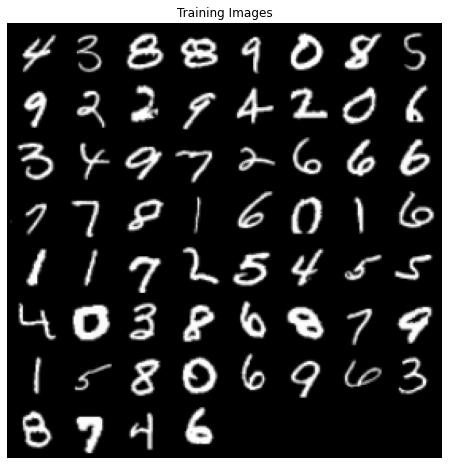

In [10]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [11]:
cgan = CGAN(ngpu=args.ngpu, device=device, lr=args.lr, nc=args.nc, ndf=args.ndf, nz=args.nz, ngf=args.ngf, beta1=args.beta)

In [12]:
 # initialize other variables
num_batches = len(dataloader)
fixed_noise = torch.randn(args.num_test_samples, args.nz, 1, 1, device=device)

Starting Training Loop...
[0/1][0/1000]	Loss_D: 1.8556	Loss_G: 0.0308	D(x): 0.2742	D(G(z)): 0.2274 / 0.9719
[0/1][50/1000]	Loss_D: 0.8914	Loss_G: 4.2504	D(x): 0.6821	D(G(z)): 0.0185 / 0.0400
[0/1][100/1000]	Loss_D: 1.6840	Loss_G: 6.4592	D(x): 0.5320	D(G(z)): 0.0140 / 0.0099
[0/1][150/1000]	Loss_D: 0.6168	Loss_G: 3.7250	D(x): 0.7337	D(G(z)): 0.0456 / 0.0486
[0/1][200/1000]	Loss_D: 1.1645	Loss_G: 2.7485	D(x): 0.7043	D(G(z)): 0.1505 / 0.1584
[0/1][250/1000]	Loss_D: 0.7628	Loss_G: 7.2168	D(x): 0.8913	D(G(z)): 0.3250 / 0.0035
[0/1][300/1000]	Loss_D: 1.1877	Loss_G: 3.0380	D(x): 0.6789	D(G(z)): 0.1243 / 0.1353
[0/1][350/1000]	Loss_D: 0.7054	Loss_G: 4.2950	D(x): 0.7552	D(G(z)): 0.1197 / 0.0531
[0/1][400/1000]	Loss_D: 0.5100	Loss_G: 5.7766	D(x): 0.8819	D(G(z)): 0.2377 / 0.0151
[0/1][450/1000]	Loss_D: 0.9775	Loss_G: 8.5561	D(x): 0.9578	D(G(z)): 0.4819 / 0.0016
[0/1][500/1000]	Loss_D: 1.3172	Loss_G: 3.9118	D(x): 0.6443	D(G(z)): 0.0495 / 0.1059
[0/1][550/1000]	Loss_D: 0.4870	Loss_G: 4.0143	D(x): 0

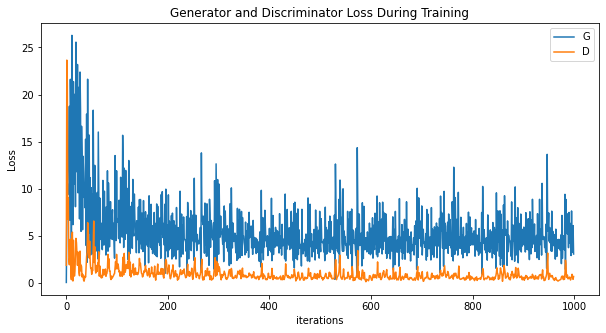

In [13]:
img_list = cgan.train(dataloader=dataloader, num_epochs=args.num_epochs, plot=args.plot)

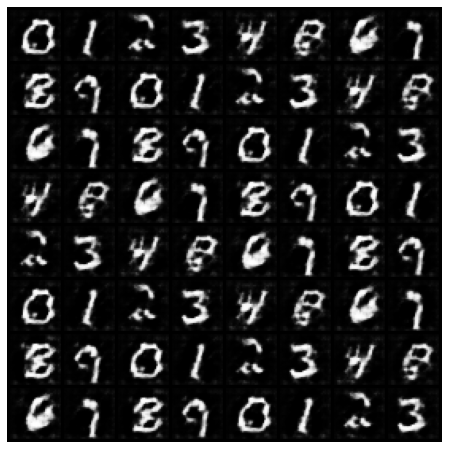

In [14]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
writergif = animation.PillowWriter(fps=30) 
ani.save(args.output_path+"fake_cgan.gif", writer=writergif)

In [15]:
#save model
model_path = "./models/"
filename = "cgan_Q3.pt"
torch.save(cgan, model_path+filename)

In [13]:
#load model
model_path = "./models/"
filename = "cgan_Q2_smoothing.pt"
cgan = torch.load(model_path+filename)

NameError: name 'img_list' is not defined

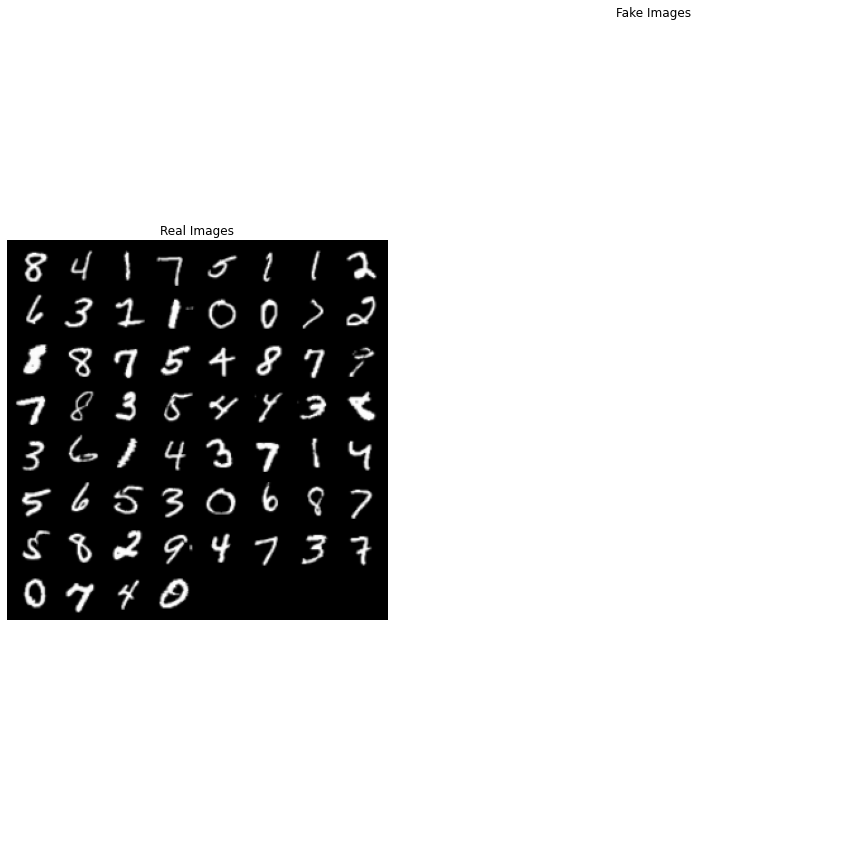

In [15]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [14]:
classifier = LeNet.Classifier(device=device, train_size=500, batch_size=10)

In [15]:
#create fake dataset and dataloader
fake_dataset, fake_dataloader = cgan.create_dataloader(num_samples=4500, batch_size=90)

In [17]:
#train classifier
model_path = "./models/"
filename = "lenet_Q2.pt"
classifier.adv_train(num_epochs=10, fake_dataloader=fake_dataloader, model_path=model_path, filename=filename)

EPOCH 0 ...
Validation Accuracy = 0.851

EPOCH 1 ...
Validation Accuracy = 0.886

EPOCH 2 ...
Validation Accuracy = 0.888

EPOCH 3 ...
Validation Accuracy = 0.888

EPOCH 4 ...
Validation Accuracy = 0.891

EPOCH 5 ...
Validation Accuracy = 0.901

EPOCH 6 ...
Validation Accuracy = 0.916

EPOCH 7 ...
Validation Accuracy = 0.915

EPOCH 8 ...
Validation Accuracy = 0.920

EPOCH 9 ...
Validation Accuracy = 0.920

Test Accuracy = 0.925
Model saved


In [18]:
#evaluate classifier on test
accuracy, predicts = classifier.evaluate(classifier.test_loader, classifier.dataset_test)
print(accuracy)

0.9251


In [36]:
#create fake dataset and dataloader
fake_test_dataset, fake_test_dataloader = cgan.create_dataloader(num_samples=1000, batch_size=1000)

In [37]:
#evaluate classifier on test
accuracy, predicts = classifier.evaluate(fake_test_dataloader, fake_test_dataset)
print(accuracy)

1.0
